# 1. 시계열

## 데이터  : 태양광 발전량


## 1-1. 데이터의 정상성을 평가하고 시계열 분석에 적합한 형태로 변환하시오.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.arima_model import ARMA,ARIMA 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.stats.diagnostic import acorr_ljungbox,het_goldfeldquandt
from scipy import stats
from scipy.signal import savgol_filter

import itertools
from sklearn.metrics import r2_score
np.random.seed(123)

from scipy.stats import probplot
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro, normaltest

## 1-2. 정상성을 충족한 후 SARIMAX를 활용하여 향후 24시간의 발전량을 예측하시오.

In [4]:
df = pd.read_csv('solar_energy.csv')

In [26]:
def adfuller_test(data) :
    result = adfuller(data)
    print("원 데이터의 ADF 값 : {}".format(result[0]))
    print('원 데이터의 P-value : {}\n'.format(result[1]))
    
    result_diff = adfuller(data.diff().dropna())
    print('\n 1차 차분 후 검정')
    print('ADF : {}'.format(result_diff[0]))
    print("ADF P-value : {}".format(result_diff[1]))

In [8]:
y = df['TARGET']

In [27]:
adfuller_test(y)

원 데이터의 ADF 값 : -13.53378574008819
원 데이터의 P-value : 2.5911368470207614e-25


 1차 차분 후 검정
ADF : -50.60066848016134
ADF P-value : 0.0


In [24]:
def kpss_test(data) :
    statistic, p_value, n_lags, critial_values = kpss(data.values)
    
    print("KPSS Statistic : {}".format(statistic))
    print("P-value : {}".format(p_value))
    print("num_lags : {}".format(n_lags))
    print("Critial_values : {}".format(critial_values))
    
    diff = data.diff().dropna()
    
    statistic_diff, p_value_diff, n_lags_diff, critial_values_diff = kpss(diff.values)
    print("\n 1차 차분 후 검정")
    print("KPSS Statistic : {}".format(statistic_diff))
    print("P-value : {}".format(p_value_diff))
    print("num_lags : {}".format(n_lags_diff))
    print("Critial_values : {}".format(critial_values_diff))

In [25]:
kpss_test(y)

KPSS Statistic : 1.2715443337828682
P-value : 0.01
num_lags : 58
Critial_values : {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

 1차 차분 후 검정
KPSS Statistic : 0.000854521946745297
P-value : 0.1
num_lags : 58
Critial_values : {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


- 1차 차분 전에는 kpss 검정이 귀무가설을 기각해서 비정상성을 보였다. 그래서 차분 후 다시 해보니 adf,kpss 둘다 정상성을 만족하게 되었다.

In [41]:
def plot_rolling(data, interval):
    
    rolmean = data.rolling(interval).mean()
    rolstd = data.rolling(interval).std()
    
    #Plot rolling statistics:
    plt.figure(figsize=(10, 6))
    plt.xlabel('Date')
    orig = plt.plot(data, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.show()

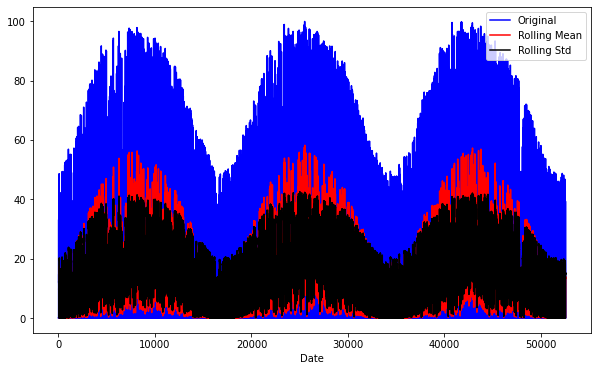

In [44]:
plot_rolling(y,30)

- 평균과 분산이 일정하지 않다

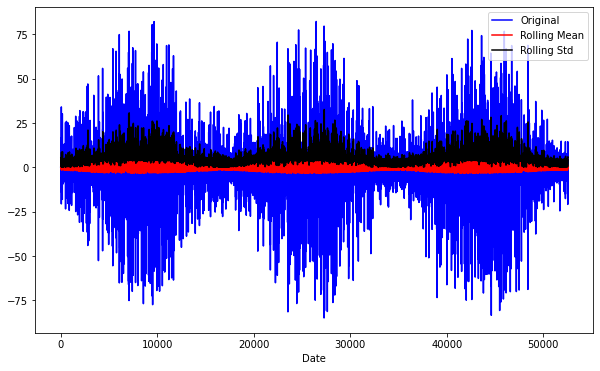

In [45]:
plot_rolling(y_diff,30)

- 차분 전보다는 일정해보이게 되었다.

In [66]:
y_train = target.iloc[:int(len(target) * 0.7),:]
y_test = target.iloc[int(len(target) * 0.7):,:]

In [68]:
model = SARIMAX(y_train,exog=None,
                             order= param,
                             seasonal_order=params,
                             enforce_invertibility=True,
                             enforce_stationarity = True)

C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [71]:
sarima_model = SARIMAX(endog=y_train,order = (2,1,0),
       seasonal_order=(1,2,1,12),enforce_invertibility=True,
       enforce_stationarity=True)

C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


## 1-3. 모형의 사후 분석을 수행하시오.(잔차분석 등)

# 2. 텍스트 마이닝

## 데이터 : Opinion Review

In [1]:
import glob, os
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

In [27]:
# 본인 PC 디렉터리 주소
# path = '/Users/kisehyun/study_code/ADP/21th/topics'

In [2]:
path = os.getcwd() + '\\topics'

In [3]:
all_files=glob.glob(os.path.join(path,'*data'))

In [4]:
f_name_list = []
opinion_text = []

In [5]:
for f in all_files :
    df = pd.read_table(f, index_col = None, header = 0, encoding = 'latin1')
    f_name = f.split("/")[-1]
    f_name = f_name.split('.')[0]
    
    f_name_list.append(f_name)
    opinion_text.append(df.to_string().replace('  ', ''))
    
data = pd.DataFrame({'filename' : f_name_list, 'opinion_text' : opinion_text})
data.head()

,filename,opinion_text
0,C:\Users\qhadk\OneDrive\바탕 화면\Data Analysis\py...,", and is very, very accurate .\n0 but for the..."
1,C:\Users\qhadk\OneDrive\바탕 화면\Data Analysis\py...,"The room was not overly big, but clean and ver..."
2,C:\Users\qhadk\OneDrive\바탕 화면\Data Analysis\py...,After I plugged it in to my USB hub on my com...
3,C:\Users\qhadk\OneDrive\바탕 화면\Data Analysis\py...,short battery lifeI moved up from an 8gb .\n0...
4,C:\Users\qhadk\OneDrive\바탕 화면\Data Analysis\py...,"6GHz 533FSB cpu, glossy display, 3, Cell 23Wh ..."


## 2-1. 해당 데이터를 전처리하고 빈도 상위 50개 단어를 워드클라우드 형태로 출력하시오(스타일은 무관)

In [7]:
data = data[['opinion_text']]

In [8]:
import re
import nltk

In [15]:
from nltk.tokenize import WordPunctTokenizer  

In [13]:
data['opinion_texts'] = [re.sub('[^a-zA-Z ]','',data['opinion_text'][i]).replace('  ',' ') for i in range(len(data))]

In [17]:
data['token'] = [WordPunctTokenizer().tokenize(data['opinion_texts'][i]) for i in range(len(data))]

In [29]:
token_list = []
for i in range(len(data)) :
    token_list.extend(WordPunctTokenizer().tokenize(data['opinion_texts'][i]))

In [37]:
token_list = [token_list[i].lower() for i in range(len(token_list))]

In [91]:
cv = CountVectorizer(max_features=1000,stop_words='english')
tdm_cv = cv.fit_transform(token_list)
cv_df = pd.DataFrame({"Word":cv.get_feature_names(),"Count" : tdm_cv.sum(axis = 0).tolist()[0]})

In [97]:
wordcloud = cv_df.sort_values(by='Count',ascending = False)[:50]
wc = WordCloud(background_color='white',width = 400, height=200,
         font_path = 'C:/Windows/Fonts/gulim.ttc')
wc.fit_words(dict(zip(wordcloud['Word'],wordcloud['Count'])))

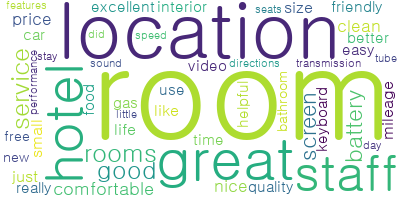

In [101]:
wc.to_image()

## 2-2. 문서들을 군집화를 수행하고 각 군집별로 주제 분석을 시행하시오.(주제수 및 군집수 무관)

In [111]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import adjusted_rand_score
from nltk.stem import WordNetLemmatizer

In [103]:
def elbow_kmeans(data,col) :
    dataf = data[[col]]
    sse = {}
    for k in range(1,10) :
        kmeans = KMeans(n_clusters=k, max_iter=1000).fit(dataf)
        dataf['Clusters'] = kmeans.labels_
        sse[k] = kmeans.inertia_
        
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Num of Cluster")
    plt.show()

In [ ]:
data['token'] = [" ".join(data['token'][i]) for i in range(len(data))]

In [160]:
tfidf_vect = TfidfVectorizer(stop_words='english',max_features=1000)

In [161]:
tfidf_vect = TfidfVectorizer(stop_words='english',max_features=1000)
ftr_vect = tfidf_vect.fit_transform(data['token'])

In [162]:
sse = {}
for k in range(1,10) :
    kmeans = KMeans(n_clusters=k, max_iter=100,init = 'k-means++',n_init=1).fit(ftr_vect)
    data['Cluster'] = kmeans.labels_
    sse[k] = kmeans.inertia_

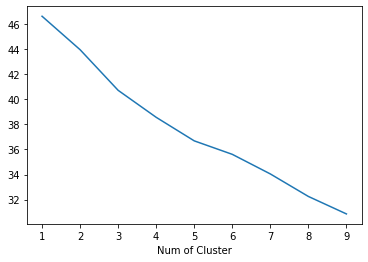

In [163]:
plt.figure()
plt.plot(list(sse.keys()),list(sse.values()))
plt.xlabel('Num of Cluster')
plt.show()

- 큰 elbow는 보이지 않는다. 그래서 임의로 3에서 끊겠다

In [174]:
kmeans = KMeans(n_clusters=3, max_iter=100, init='k-means++',n_init=1).fit(ftr_vect)

In [175]:
data['Cluster']= kmeans.predict(ftr_vect)

In [176]:
ftr_vect.shape

(51, 1000)

In [167]:
from sklearn.decomposition import TruncatedSVD

In [168]:
from sklearn.decomposition import LatentDirichletAllocation

In [170]:
latent =LatentDirichletAllocation(n_components=10,learning_method='online',random_state=777,max_iter=1)

In [201]:
cluster0 = data.loc[data['Cluster']==0,'token']
cluster1 = data.loc[data['Cluster']==1,'token']
cluster2 = data.loc[data['Cluster']==2,'token']

In [220]:
tfidf = TfidfVectorizer(max_features=1000,stop_words='english')
lda_model=LatentDirichletAllocation(n_components=4,learning_method='online',random_state=777,max_iter=1)

In [231]:
cluster_list = [cluster0,cluster1,cluster2]

In [ ]:
def get_topics(components, feature_names, n=5):
    for idx, topic in enumerate(components):
        print("Topic %d:" % (idx+1), [(feature_names[i], topic[i].round(2)) for i in topic.argsort()[:-n - 1:-1]])
get_topics(lda_model.components_,terms)

In [232]:
for cl in cluster_list :
    tf_value = tfidf.fit_transform(cl)
    lda_value = lda_model.fit_transform(tf_value)
    terms = tfidf.get_feature_names()
    
    print(get_topics(lda_model.components_,terms))

Topic 1: [('reduce', 1.26), ('battery', 1.19), ('intuitive', 1.17), ('signal', 1.16), ('following', 1.16)]
Topic 2: [('disappointed', 1.13), ('instructions', 1.13), ('fi', 1.13), ('lines', 1.11), ('display', 1.1)]
Topic 3: [('accurate', 1.17), ('speed', 1.13), ('voice', 1.12), ('slow', 1.1), ('isnt', 1.1)]
Topic 4: [('font', 1.18), ('kindle', 1.18), ('fact', 1.14), ('eyesight', 1.13), ('size', 1.09)]
None
Topic 1: [('rooms', 1.26), ('recommending', 1.26), ('indian', 1.17), ('fact', 1.16), ('sink', 1.15)]
Topic 2: [('service', 1.44), ('room', 1.35), ('location', 1.32), ('great', 1.23), ('hotel', 1.21)]
Topic 3: [('sofa', 1.1), ('inside', 1.09), ('come', 1.08), ('guy', 1.08), ('experience', 1.08)]
Topic 4: [('eating', 1.13), ('easy', 1.12), ('coffee', 1.11), ('london', 1.08), ('towels', 1.07)]
None
Topic 1: [('roomy', 1.26), ('high', 1.18), ('levels', 1.17), ('sold', 1.14), ('short', 1.1)]
Topic 2: [('mileage', 1.36), ('seats', 1.22), ('comfortable', 1.19), ('gas', 1.17), ('excellent', 1

## 2-3. 군집별로 핵심 단어 10개씩을 추출(군집 중심과 가장 가까운 단어)하시오.

In [277]:
cl0 = kmeans.cluster_centers_.argsort()[:,::-1][:,:10][0]
cl1 = kmeans.cluster_centers_.argsort()[:,::-1][:,:10][1]
cl2 = kmeans.cluster_centers_.argsort()[:,::-1][:,:10][2]

In [272]:
df = pd.DataFrame({"Word" : tfidf.get_feature_names()})

In [274]:
df.reset_index(inplace = True)

In [283]:
df.loc[cl0.tolist()]['Word'].tolist()

['selected',
 'believe',
 'listen',
 'extended',
 'ls',
 'software',
 'steps',
 'watching',
 'live',
 'highway']

In [284]:
df.loc[cl1.tolist()]['Word'].tolist()

['shifts',
 'jbl',
 'saying',
 'storage',
 'say',
 'hit',
 'mediocre',
 'controls',
 'beat',
 'improving']

In [285]:
df.loc[cl2.tolist()]['Word'].tolist()

['lets',
 'nav',
 'previously',
 'sensor',
 'cyl',
 'rely',
 'hunts',
 'cold',
 'trim',
 'wanted']

## 2-4. 비지도학습을 활용하여 감성분석을 시행하시오.

In [287]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [289]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\qhadk\AppData\Roaming\nltk_data...


True

In [290]:
senti_analyzer = SentimentIntensityAnalyzer()

In [292]:
senti_analyzer.polarity_scores(data['token'][0])

{'neg': 0.034, 'neu': 0.813, 'pos': 0.153, 'compound': 0.9994}

- neg는 부정 감성 지수, 'neu'는 중립적인 감성 지수, 'pos'는 긍정 감성 지수, 그리고 compound는 neg, neu, pos score를 적절히 조합해 -1에서 1사이의 감성 지수를 표현한 값입니다.

- 보통 0.1이상이면 긍정 그 이하이면 부정

In [298]:
for i in range(len(data)) :
    value = senti_analyzer.polarity_scores(data['token'][i])['compound']
    if value >= 0.1 :
        print("{} Compound : {}, 긍정입니다.".format(i,value))
    else :
        print("{} Compound : {}, 부정입니다.".format(i,value))

0 Compound : 0.9994, 긍정입니다.
1 Compound : 0.9999, 긍정입니다.
2 Compound : 0.9976, 긍정입니다.
3 Compound : 0.9996, 긍정입니다.
4 Compound : 1.0, 긍정입니다.
5 Compound : 0.9994, 긍정입니다.
6 Compound : 0.9998, 긍정입니다.
7 Compound : 1.0, 긍정입니다.
8 Compound : 0.9993, 긍정입니다.
9 Compound : 0.9985, 긍정입니다.
10 Compound : 0.9997, 긍정입니다.
11 Compound : 0.9996, 긍정입니다.
12 Compound : 0.9998, 긍정입니다.
13 Compound : 0.9999, 긍정입니다.
14 Compound : 0.9995, 긍정입니다.
15 Compound : 1.0, 긍정입니다.
16 Compound : 0.9999, 긍정입니다.
17 Compound : 0.9999, 긍정입니다.
18 Compound : 0.9999, 긍정입니다.
19 Compound : 0.9999, 긍정입니다.
20 Compound : 1.0, 긍정입니다.
21 Compound : 1.0, 긍정입니다.
22 Compound : 0.9999, 긍정입니다.
23 Compound : 0.9997, 긍정입니다.
24 Compound : 0.9994, 긍정입니다.
25 Compound : 0.9996, 긍정입니다.
26 Compound : 0.999, 긍정입니다.
27 Compound : 0.9991, 긍정입니다.
28 Compound : 1.0, 긍정입니다.
29 Compound : 0.9983, 긍정입니다.
30 Compound : 1.0, 긍정입니다.
31 Compound : 1.0, 긍정입니다.
32 Compound : 1.0, 긍정입니다.
33 Compound : 0.975, 긍정입니다.
34 Compound : 0.9997, 긍정입니다.
35 Compound : 0.9998, 긍정